### Unsupervised Analysis of Congressional Laws

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline


#gensim
from gensim import corpora, models, similarities, matutils

#sklearn
from sklearn.feature_extraction.text import (CountVectorizer, 
                                             TfidfTransformer,
                                             TfidfVectorizer)
from sklearn.cluster import KMeans
from sklearn.decomposition import (NMF,
                                   TruncatedSVD)
from sklearn.preprocessing import Normalizer
from sklearn.manifold import TSNE

__Import data__

In [2]:
laws_df = pd.read_csv('all_laws.csv',index_col=0)

In [3]:
laws_names = list(laws_df.index)
laws_list = laws_df['text'].tolist()

__Import Law Summary Data__

In [4]:
laws_summarys = pd.read_csv('laws_summary.csv')

__ Import Custom Stop Words__

In [5]:
custom_stopwords_df = pd.read_csv('custom_stopwords.csv')
custom_sw = frozenset(custom_stopwords_df.iloc[:,1])

In [6]:
custom_sw

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'ante',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'april',
           'are',
           'around',
           'as',
           'at',
           'august',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
 

__Count Vectorizer__

In [7]:
count_vectorizer = CountVectorizer(ngram_range=(0, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]{3,100}\\b",
                                   max_df=0.8,
                                   min_df = 50)
count_vectorizer.fit(laws_list)



CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=None, min_df=50,
        ngram_range=(0, 2), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='\\b[a-z][a-z]{3,100}\\b',
        tokenizer=None, vocabulary=None)

In [8]:
# Create the term-document matrix
# Transpose it so the terms are the rows
counts = count_vectorizer.transform(laws_list).transpose()

In [9]:
np.shape(counts)

(17274, 3896)

__Convert to gensim__

We need to convert our sparse `scipy` matrix to a `gensim`-friendly object called a Corpus:

In [10]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(counts)

__Map matrix rows to words (tokens)__

We need to save a mapping (dict) of row id to word (token) for later use by gensim:

In [11]:
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

In [12]:
len(id2word)

17274

## LDA
At this point we can simply plow ahead in creating an LDA model.  It requires our corpus of word counts, mapping of row ids to words, and the number of topics (3).

In [13]:
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=5, id2word=id2word, passes=3)

In [14]:
lda.print_topics(num_words=20)

[(0,
  '0.010*"subsection" + 0.009*"paragraph" + 0.008*"secretary" + 0.007*"inserting" + 0.007*"amended" + 0.006*"striking" + 0.006*"year" + 0.006*"date" + 0.005*"general" + 0.005*"subparagraph" + 0.005*"title" + 0.005*"following" + 0.004*"state" + 0.004*"federal" + 0.004*"term" + 0.004*"plan" + 0.004*"described" + 0.004*"respect" + 0.003*"information" + 0.003*"period"'),
 (1,
  '0.012*"defense" + 0.011*"secretary" + 0.009*"subsection" + 0.007*"title" + 0.006*"department" + 0.006*"program" + 0.006*"report" + 0.005*"paragraph" + 0.005*"national" + 0.005*"year" + 0.005*"military" + 0.005*"amended" + 0.004*"inserting" + 0.004*"following" + 0.004*"section title" + 0.004*"striking" + 0.004*"fiscal" + 0.004*"fiscal year" + 0.004*"date" + 0.004*"general"'),
 (2,
  '0.009*"state" + 0.008*"secretary" + 0.008*"inserting" + 0.007*"subsection" + 0.007*"striking" + 0.007*"program" + 0.007*"paragraph" + 0.006*"year" + 0.005*"education" + 0.005*"amended" + 0.005*"title" + 0.005*"general" + 0.005*"fis

In [15]:
# Transform the docs from the word space to the topic space (like "transform" in sklearn)
lda_corpus = lda[corpus]
lda_corpus

In [16]:
# Store the documents' topic vectors in a list so we can take a peak
lda_docs = [doc for doc in lda_corpus]

In [17]:
len(lda_docs)

3896

In [18]:
lda_docs[900]

[(0, 0.83333352937096972), (3, 0.16002046880759804)]

## NMF

In [10]:
vectorizer = TfidfVectorizer(ngram_range=(1,2),  
                                   stop_words = custom_sw, 
                                   token_pattern="\\b[a-z][a-z]{2,100}\\b",
                                   max_df = 0.90,
                                   min_df = 50)

In [11]:
dtm = vectorizer.fit_transform(laws_list) 
#pd.DataFrame(dtm.toarray(), index=laws_names, columns=vectorizer.get_feature_names()).head(10)

In [12]:
dtm

<3896x17010 sparse matrix of type '<class 'numpy.float64'>'
	with 2461716 stored elements in Compressed Sparse Row format>

In [13]:
num_groups = 20
nmf_model = NMF(num_groups )
dtm_nmf = nmf_model.fit_transform(dtm)
dtm_nmf = Normalizer(copy=False).fit_transform(dtm_nmf)

In [21]:
features = vectorizer.get_feature_names()
print("These are the documents extracted from the data and their respective topics:")
print('')
#nmf.components_


num_words = 20
for topicidx, topic in enumerate(nmf_model.components_):
    
    print('Topic: ' + str(topicidx))
    print("Keywords: " + " ".join([features[i] for i in topic.argsort()[:-1*num_words-1:-1]]) )# 
    print('')

These are the documents extracted from the data and their respective topics:

Topic: 0
Keywords: office building post office building post facility service located facility united states postal postal service postal reference located building approved building references building note service designation facility designate facility states facility facility referred

Topic: 1
Keywords: secretary health program state shall fiscal services research year care fiscal year secretary shall information report including grant national public health activities programs

Topic: 2
Keywords: courthouse states courthouse courthouse located courthouse note courthouse references courthouse approved courthouse referred street designate united reference designation united states united assembled designation infrastructure congressional comm transportation located act designate regulation document reference law map regulation

Topic: 3
Keywords: inserting striking amended striking inserting amended strik

__Investigate whether Topics identified match title__

In [15]:
def rank_df(df,rank,num_groups):
    coln = 'MAX' + str(rank) 
    sortID = np.argpartition(
        -df[list(np.arange(0,num_groups))].values,rank,axis=1)[:,rank-1]
    df[coln] = df.columns[sortID]

In [16]:
nmf_df = pd.DataFrame(dtm_nmf, index = laws_df.index)

rank_df(nmf_df,1,num_groups)
rank_df(nmf_df,2,num_groups)
rank_df(nmf_df,3,num_groups)
nmf_df.reset_index(inplace=True)
nmf_df.rename(columns={'index':'id'},inplace=True)

nmf_df = nmf_df.merge(laws_summarys[['id','title']],on = 'id',how = 'left')

In [17]:
# Random View of Laws
pd.options.display.max_colwidth = 100
nmf_df[['id','title','MAX1','MAX2','MAX3']].iloc[
    np.random.choice(np.arange(0,len(laws_list)),
                     size = 10,
                     replace = False)]

,id,title,MAX1,MAX2,MAX3
1971,c109publ403,H.R.5857 - To designate the facility of the United States Postal Service located at 1501 South C...,0,6,6
2050,c109publ475,H.R.1245 - Johanna's Law 109th Congress (2005-2006),1,8,16
735,c106publ17,H.R.774 - Women's Business Center Amendments Act of 1999 106th Congress (1999-2000),15,3,14
576,c105publ318,H.R.4151 - Identity Theft and Assumption Deterrence Act of 1998 105th Congress (...,7,3,11
1368,c108publ309,"H.J.Res.107 - Making continuing appropriations for the fiscal year 2005, and for other purposes....",9,5,13
1360,c108publ301,S.2712 - A bill to preserve the ability of the Federal Housing Administration to insure mortgage...,9,14,15
991,c107publ309,"H.R.3988 - To amend title 36, United States Code, to clarify the requirements for eligibility in...",3,7,5
1844,c109publ29,H.R.1236 - To designate the facility of the United States Postal Service located at 750 4th Stre...,6,17,14
3714,c114publ259,H.R.5509 - To name the Department of Veterans Affairs temporary lodging facility in Indianapolis...,8,6,15
1733,c109publ19,H.R.3021 - TANF Extension Act of 2005 109th Congress (2005-2006),9,1,19


## Try LSA too!

In [27]:
vectorizer2 = TfidfVectorizer(
    ngram_range=(1,2),  
    stop_words = custom_sw, 
    token_pattern="\\b[a-z][a-z]{2,100}\\b",
    max_df = 0.80,
    min_df = 50)

dtm2 = vectorizer2.fit_transform(laws_list) 

In [28]:
# Fit LSA. Use algorithm = “randomized” for large datasets 

num_groups2 = 15
lsa_model = TruncatedSVD(num_groups2, algorithm = 'randomized')
dtm_lsa = lsa_model.fit_transform(dtm2)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)

In [29]:
features = vectorizer2.get_feature_names()
print("These are the documents extracted from the data and their respective topics:")
print('')
#nmf.components_


num_words = 20
for topicidx, topic in enumerate(lsa_model.components_):
    
    print('Topic: ' + str(topicidx))
    print("Keywords: " + " ".join([features[i] for i in topic.argsort()[:-1*num_words-1:-1]]) )# 
    print('')

These are the documents extracted from the data and their respective topics:

Topic: 0
Keywords: post office post office building building facility service located facility united states postal postal service postal reference located service states facility facility referred designation facility designate facility map regulation law map paper record

Topic: 1
Keywords: secretary inserting striking amended title year state fiscal federal program provided national available funds date fiscal year general code following amended striking

Topic: 2
Keywords: courthouse states courthouse federal building federal building land courthouse located secretary courthouse note courthouse references courthouse approved street infrastructure congressional courthouse referred comm transportation building located national transportation infrastructure assembled designation map

Topic: 3
Keywords: inserting striking courthouse states courthouse amended amended striking striking inserting federal buildin

In [30]:
lsa_df = pd.DataFrame(dtm_lsa, index = laws_df.index)

In [31]:
rank_df(lsa_df,1,num_groups=num_groups2)
rank_df(lsa_df,2,num_groups=num_groups2)
rank_df(lsa_df,3,num_groups=num_groups2)
lsa_df.reset_index(inplace=True)
lsa_df.rename(columns={'index':'id'},inplace=True)

lsa_df = lsa_df.merge(laws_summarys[['id','title']],on = 'id',how = 'left')

In [32]:
# Random View of Laws
pd.options.display.max_colwidth = 100
nmf_df[['id','title','MAX1','MAX2','MAX3']].iloc[
    np.random.choice(np.arange(0,len(laws_list)),
                     size = 10,
                     replace = False)]

,id,title,MAX1,MAX2,MAX3
2363,c110publ322,S.2450 - A bill to amend the Federal Rules of Evidence to address the waiver of the attorney-cli...,7,14,19
736,c106publ18,"H.R.171 - To authorize appropriations for the Coastal Heritage Trail Route in New Jersey, and fo...",3,10,4
3231,c112publ90,"H.R.2845 - Pipeline Safety, Regulatory Certainty, and Job Creation Act of 2011 1...",1,7,18
706,c105publ80,"H.R.672 - To make technical amendments to certain provisions of title 17, United States Code. ...",3,7,7
2406,c110publ361,"H.R.5265 - Paul D. Wellstone Muscular Dystrophy Community Assistance, Research, and Education Am...",1,19,1
908,c107publ234,H.R.4558 - To extend the Irish Peace Process Cultural and Training Program. 107t...,3,10,19
3046,c112publ179,H.R.1272 - Minnesota Chippewa Tribe Judgment Fund Distribution Act of 2012 112th...,18,9,18
2354,c110publ314,H.R.4040 - Consumer Product Safety Improvement Act of 2008 110th Congress (2007-...,7,10,1
2072,c109publ60,H.R.1132 - National All Schedules Prescription Electronic Reporting Act of 2005 ...,1,7,15
707,c105publ81,H.R.708 - To require the Secretary of the Interior to conduct a study concerning grazing use of ...,4,1,17


__TSNE Visualization (NMF)__

In [18]:
np.shape(dtm_nmf)

(3896, 20)

In [19]:
tsne_model = TSNE(learning_rate=300,
                  perplexity=50,
                  early_exaggeration=4.0,
                  n_iter=5000,
                  verbose=2,
                  random_state = 101)

tsne_nmf = tsne_model.fit_transform(dtm_nmf)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 3896
[t-SNE] Computed conditional probabilities for sample 2000 / 3896
[t-SNE] Computed conditional probabilities for sample 3000 / 3896
[t-SNE] Computed conditional probabilities for sample 3896 / 3896
[t-SNE] Mean sigma: 0.055469
[t-SNE] Iteration 25: error = 1.7279922, gradient norm = 0.0003853
[t-SNE] Iteration 25: gradient norm 0.000385. Finished.
[t-SNE] Iteration 50: error = 1.5604767, gradient norm = 0.0079247
[t-SNE] Iteration 75: error = 1.4522717, gradient norm = 0.0057564
[t-SNE] Iteration 100: error = 1.4287299, gradient norm = 0.0054028
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.428730
[t-SNE] Iteration 125: error = 1.2779316, gradient norm = 0.0036423
[t-SNE] Iteration 150: error = 1.2335733, gradient norm = 0.0032759
[t-SNE] Iteration 175: error = 1.2227577, gradient norm = 0.0031663
[t-SNE] Iteration 

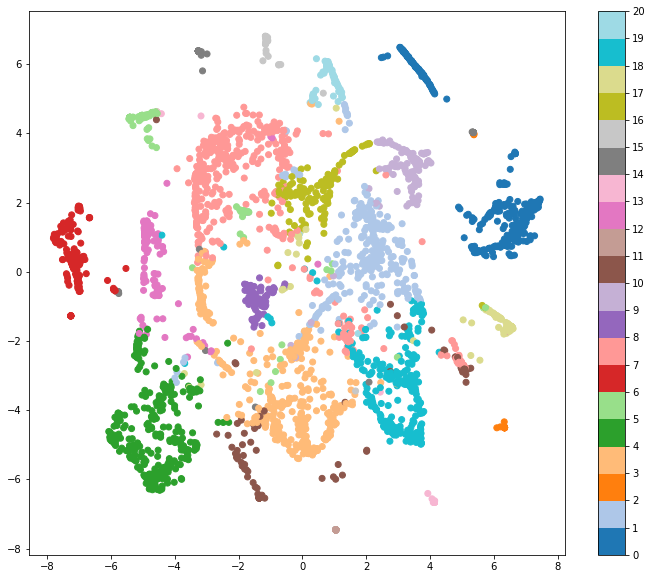

In [20]:
plt.figure(figsize=(12,10))
plt.scatter(tsne_nmf[:,0], tsne_nmf[:,1], c=nmf_df.MAX1, cmap=plt.cm.get_cmap("tab20", num_groups))
plt.colorbar(ticks=range(num_groups+1))
plt.clim(0, num_groups)
plt.show()

__TSNE Visualization (LSA)__

tsne_model = TSNE(learning_rate=300,
                  perplexity=50,
                  n_iter=5000,
                  verbose=2,random_state = 101)

tsne_lsa = tsne_model.fit_transform(dtm_lsa)

In [35]:
tsne_model = TSNE(learning_rate=200,
                  perplexity=50,
                  n_iter=5000,
                  verbose=2,random_state = 101)

tsne_lsa = tsne_model.fit_transform(dtm_lsa)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 3896
[t-SNE] Computed conditional probabilities for sample 2000 / 3896
[t-SNE] Computed conditional probabilities for sample 3000 / 3896
[t-SNE] Computed conditional probabilities for sample 3896 / 3896
[t-SNE] Mean sigma: 0.067688
[t-SNE] Iteration 25: error = 1.7732246, gradient norm = 0.0000732
[t-SNE] Iteration 25: gradient norm 0.000073. Finished.
[t-SNE] Iteration 50: error = 1.7561995, gradient norm = 0.0129696
[t-SNE] Iteration 75: error = 1.6721779, gradient norm = 0.0095870
[t-SNE] Iteration 100: error = 1.6484824, gradient norm = 0.0085859
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.648482
[t-SNE] Iteration 125: error = 1.5028117, gradient norm = 0.0049898
[t-SNE] Iteration 150: error = 1.4589295, gradient norm = 0.0044649
[t-SNE] Iteration 175: error = 1.4478209, gradient norm = 0.0043357
[t-SNE] Iteration 

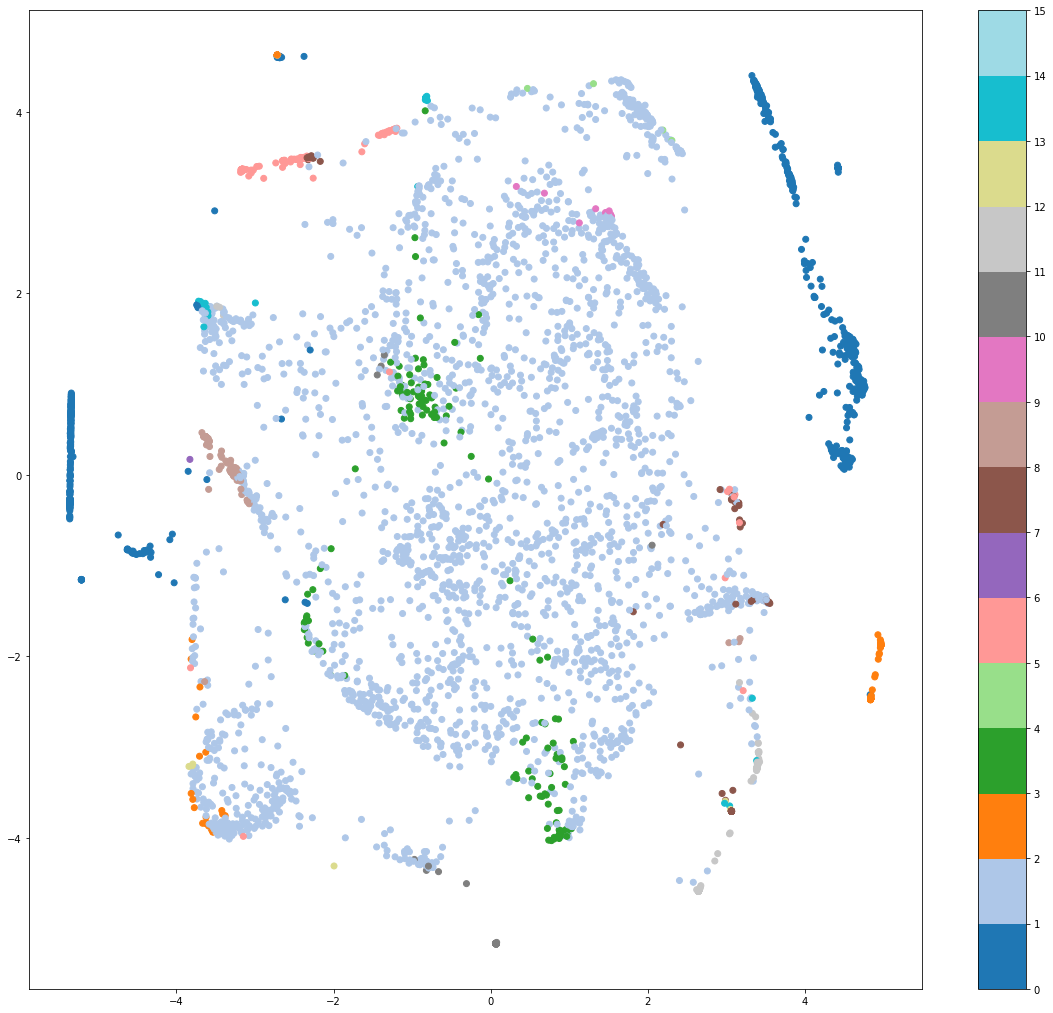

In [36]:
plt.figure(figsize=(20,18))
plt.scatter(tsne_lsa[:,0],
            tsne_lsa[:,1], 
            c=lsa_df.MAX1, 
            cmap=plt.cm.get_cmap("tab20",
                                 num_groups2))
plt.colorbar(ticks=range(num_groups2+1))
plt.clim(0, num_groups2)
plt.show()